# **Imports**

In [5]:
import os
import pandas as pd
import geopandas as gpd
from glob import glob
import rasterio as rio
import matplotlib.pyplot as plt
import pyodbc


# **1/ Loading Datasets**

In [6]:
# Algeria fires
fires_dz = pd.read_csv("../Datasets/Fire dataset/viirs-jpss1_2024_Algeria.csv")
fires_dz_gdf = gpd.GeoDataFrame(
    fires_dz,
    geometry=gpd.points_from_xy(fires_dz.longitude, fires_dz.latitude),
    crs="EPSG:4326"
)

# Tunisia fires
fires_tn = pd.read_csv("../Datasets/Fire dataset/viirs-jpss1_2024_Tunisia.csv")
fires_tn_gdf = gpd.GeoDataFrame(
    fires_tn,
    geometry=gpd.points_from_xy(fires_tn.longitude, fires_tn.latitude),
    crs="EPSG:4326"
)

# Merge both
fires = pd.concat([fires_dz_gdf, fires_tn_gdf], ignore_index=True)
print(fires.head())

   latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  27.72818    9.87200      295.51  0.76   0.77  2024-01-01         3   
1  28.63288    9.77909      301.80  0.79   0.78  2024-01-01         3   
2  28.64012    9.77953      298.65  0.79   0.78  2024-01-01         3   
3  36.74886    6.25409      338.04  0.46   0.39  2024-01-01       141   
4  35.87978    4.44782      309.49  0.41   0.37  2024-01-01       141   

  satellite instrument confidence  version  bright_ti5   frp daynight  type  \
0       N20      VIIRS          n        2      277.66  1.24        N     2   
1       N20      VIIRS          n        2      277.05  1.57        N     2   
2       N20      VIIRS          n        2      277.04  1.34        N     2   
3       N20      VIIRS          n        2      257.28  5.21        N     2   
4       N20      VIIRS          n        2      272.08  1.58        N     2   

                   geometry  
0    POINT (9.872 27.72818)  
1  POINT (9.77909 28.63288

   ID  GRIDCODE          AREA       LCCCODE  \
0   4       210  6.228187e+06  7001 // 8001   
1   2       210  6.242408e+06  7001 // 8001   
2   1       210  1.482995e+06  7001 // 8001   
3   8        50  4.590841e+08  21497-121340   
4  13       210  6.371533e+06  7001 // 8001   

                                            geometry  
0  POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6...  
1  POLYGON ((7.18084 37.07917, 7.17998 37.08091, ...  
2  POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7...  
3  POLYGON ((6.12361 36.68472, 6.12361 36.69306, ...  
4  POLYGON ((6.26181 37.02361, 6.26193 37.02514, ...  
EPSG:4326
EPSG:4326
45373 81474 1


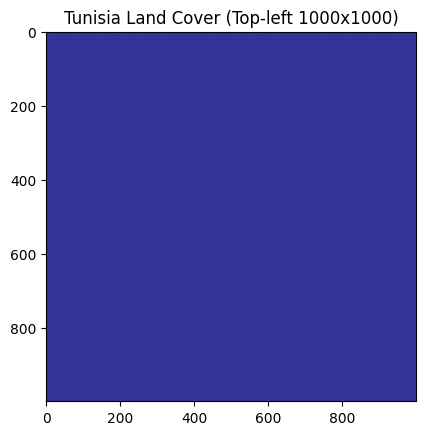

In [8]:
# 1.3 Land cover (FAO Globcover shapefile)
lc_dz = gpd.read_file("../Datasets/Land Cover dataset/Algeria/dza_gc_adg.shp")
print(lc_dz.head())
print(lc_dz.crs)


lc_tn = rio.open("../Datasets/Land Cover dataset/Tunisia/LCLU.LCTNS2022.tif")
print(lc_tn.crs)
print(lc_tn.width, lc_tn.height, lc_tn.count)

# Plot a small window (e.g., top-left 1000x1000 pixels) to avoid MemoryError
window = rio.windows.Window(0, 0, 1000, 1000)
lc_tn_small = lc_tn.read(1, window=window)
plt.imshow(lc_tn_small, cmap="terrain")
plt.title("Tunisia Land Cover (Top-left 1000x1000)")
plt.show()

In [9]:
# 1.4 Climate (WorldClim monthly GeoTIFF)

tmin_paths = sorted(glob("../Datasets/Climate dataset/wc2.1_cruts4.09_2.5m_tmin_2020-2024/*.tif"))
tmax_paths = sorted(glob("../Datasets/Climate dataset/wc2.1_cruts4.09_2.5m_tmax_2020-2024/*.tif"))
prec_paths = sorted(glob("../Datasets/Climate dataset/wc2.1_cruts4.09_2.5m_prec_2020-2024/*.tif"))

# Example: open one to inspect
with rio.open(tmax_paths[0]) as src:
    print(src.crs, src.transform, src.count, src.width, src.height)


print(len(prec_paths))  # should show ~60 files (2020-01 → 2024-12)


EPSG:4326 | 0.04, 0.00,-180.00|
| 0.00,-0.04, 90.00|
| 0.00, 0.00, 1.00| 1 8640 4320
60


In [10]:
# 1.5 Elevation (GMTED2010 mean, 7.5″ tiles)
elev_coverage = gpd.read_file("../Datasets/Elevation dataset/gmted2010.shp")
print(elev_coverage.head())
print(elev_coverage.crs)

                 ID                                           geometry
0  5e83a1f36d8572da  POLYGON ((180.01 -70, 180.01 -90, 180.00995 -9...
EPSG:4326


In [14]:
# 1.6 Soil (HWSD v2)

conn_str = r"Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Datasets/Soil dataset/HWSD2.mdb;"
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()

tables = [row.table_name for row in cursor.tables()]
print(tables)

soil_df = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)
soil_df.head()

['MSysAccessStorage', 'MSysAccessXML', 'MSysACEs', 'MSysIMEXColumns', 'MSysIMEXSpecs', 'MSysNameMap', 'MSysNavPaneGroupCategories', 'MSysNavPaneGroups', 'MSysNavPaneGroupToObjects', 'MSysNavPaneObjectIDs', 'MSysObjects', 'MSysQueries', 'MSysRelationships', 'D_ADD_PROP', 'D_AWC', 'D_COVERAGE', 'D_DRAINAGE', 'D_FAO90', 'D_IL', 'D_KOPPEN', 'D_PHASE', 'D_ROOT_DEPTH', 'D_ROOTS', 'D_SWR', 'D_TEXTURE', 'D_TEXTURE_SOTER', 'D_TEXTURE_USDA', 'D_WRB_PHASES', 'D_WRB2', 'D_WRB2code', 'D_WRB4', 'HWSD2_LAYERS', 'HWSD2_LAYERS_METADATA', 'HWSD2_SMU', 'HWSD2_SMU_METADATA', 'WRB_Class', 'WRB_Layer', 'WRB_Library']


C:\Users\E15\AppData\Local\Temp\ipykernel_4796\808103362.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  soil_df = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)


,ID,HWSD2_SMU_ID,WISE30s_SMU_ID,HWSD1_SMU_ID,COVERAGE,SHARE,WRB4,WRB_PHASES,WRB2,WRB2_CODE,...,REF_BULK_DENSITY,BULK_DENSITY,DRAINAGE,ROOT_DEPTH,AWC,PHASE1,PHASE2,ROOTS,IL,ADD_PROP
0,669,12707,WD10012707,12707,3,40,ALfr,ALfr,AL,2,...,1.63,1.35,MW,1,168,NaN,NaN,NaN,NaN,0.0
1,695,11825,WD30011825,11825,2,100,ALfr,ALfr,AL,2,...,1.76,1.44,MW,1,152,NaN,NaN,NaN,NaN,0.0
2,696,11823,WD30011823,11823,2,100,ALfr,ALfr,AL,2,...,1.76,1.44,MW,1,152,NaN,NaN,NaN,NaN,0.0
3,697,13458,WD30013458,13458,3,100,ALfr,ALfr,AL,2,...,1.76,1.44,MW,1,152,NaN,NaN,NaN,NaN,0.0
4,698,11824,WD30011824,11824,2,100,ALfr,ALfr,AL,2,...,1.76,1.44,MW,1,152,NaN,NaN,NaN,NaN,0.0


## **2/ AOI (Algeria + Tunisia polygon)**

In [ ]:
# Create necessary directories
os.makedirs("../Datasets/processed/vectors", exist_ok=True)
os.makedirs("../Datasets/processed/rasters/climate/prec", exist_ok=True)
os.makedirs("../Datasets/processed/rasters/climate/tmin", exist_ok=True)
os.makedirs("../Datasets/processed/rasters/climate/tmax", exist_ok=True)
os.makedirs("../Datasets/processed/rasters/landcover_tn", exist_ok=True)
os.makedirs("../Datasets/processed/rasters/elevation", exist_ok=True)



In [ ]:
# quick and reliable AOI from Natural Earth
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
aoi = world[world["name"].isin(["Algeria","Tunisia"])].to_crs("EPSG:4326").dissolve()
aoi_path = "../Datasets/processed/vectors/aoi_dz_tn.gpkg"
aoi.to_file(aoi_path, layer="aoi", driver="GPKG")
aoi



In [ ]:
# 2) Vector clip helper + apply (fires + DZ land cover)
def clip_vector(gdf, aoi_gdf):
    gdf = gdf.to_crs(aoi_gdf.crs)
    return gpd.clip(gdf, aoi_gdf)

# Fires (points)
fires_clipped = clip_vector(fires, aoi)
fires_clipped.to_file("../Datasets/processed/vectors/firms_2024_dz_tn.gpkg",
                      layer="fires", driver="GPKG")

# Land cover Algeria (vector)
lc_dz = lc_dz.to_crs(aoi.crs)   # you already loaded it above
lc_dz_clipped = clip_vector(lc_dz, aoi)
lc_dz_clipped.to_file("../Datasets/processed/vectors/landcover_dz_gc2005.gpkg",
                      layer="lc_dz", driver="GPKG")



In [ ]:
# 3) Raster clip helper (mask by AOI)
import json
from rasterio.mask import mask

def clip_raster_to_aoi(in_tif, out_tif, aoi_gdf):
    with rio.open(in_tif) as src:
        aoi_proj = aoi_gdf.to_crs(src.crs)
        shapes = [json.loads(aoi_proj.geometry.iloc[0].to_json())]
        out_img, out_transform = mask(src, shapes=shapes, crop=True)
        meta = src.meta.copy()
        meta.update({"height": out_img.shape[1],
                     "width":  out_img.shape[2],
                     "transform": out_transform})
    with rio.open(out_tif, "w", **meta) as dst:
        dst.write(out_img)


In [ ]:
# 3.a) Clip Tunisia land cover (raster)
in_tn_lc = "../Datasets/Land Cover dataset/Tunisia/LCLU.LCTNS2022.tif"
out_tn_lc = "../Datasets/processed/rasters/landcover_tn/LCLU.LCTNS2022_dztn.tif"
clip_raster_to_aoi(in_tn_lc, out_tn_lc, aoi)



In [ ]:
# 3.b) Clip climate rasters (prec/tmin/tmax)
from glob import glob
import os

tmin_paths = sorted(glob("../Datasets/Climate dataset/wc2.1_cruts4.09_2.5m_tmin_2020-2024/*.tif"))
tmax_paths = sorted(glob("../Datasets/Climate dataset/wc2.1_cruts4.09_2.5m_tmax_2020-2024/*.tif"))
prec_paths = sorted(glob("../Datasets/Climate dataset/wc2.1_cruts4.09_2.5m_prec_2020-2024/*.tif"))

for p in prec_paths:
    out = os.path.join("../Datasets/processed/rasters/climate/prec",
                       os.path.basename(p).replace(".tif","_dztn.tif"))
    clip_raster_to_aoi(p, out, aoi)

for p in tmin_paths:
    out = os.path.join("../Datasets/processed/rasters/climate/tmin",
                       os.path.basename(p).replace(".tif","_dztn.tif"))
    clip_raster_to_aoi(p, out, aoi)

for p in tmax_paths:
    out = os.path.join("../Datasets/processed/rasters/climate/tmax",
                       os.path.basename(p).replace(".tif","_dztn.tif"))
    clip_raster_to_aoi(p, out, aoi)



In [ ]:
# 4) Elevation note (what you have now)

from rasterio.merge import merge

clipped_elev = sorted(glob("../Datasets/processed/rasters/elevation/*_dztn.tif"))
if clipped_elev:
    srcs = [rio.open(p) for p in clipped_elev]
    mosaic, transform = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({"height": mosaic.shape[1], "width": mosaic.shape[2], "transform": transform})
    out_dem = "../Datasets/processed/rasters/elevation/dz_tn_gmted_mean_250m.tif"
    with rio.open(out_dem, "w", **meta) as dst:
        dst.write(mosaic)
    for s in srcs: s.close()



In [15]:
# 6) Quick sanity checks
# CRS consistency
print("AOI CRS:", aoi.crs)
print("Fires CRS:", fires_clipped.crs)
print("DZ Landcover CRS:", lc_dz_clipped.crs)

# One raster check
with rio.open(glob("../Datasets/processed/rasters/climate/prec/*_dztn.tif")[0]) as src:
    print("PREC clipped:", src.crs, src.width, src.height)

NameError: name 'aoi' is not defined

# **3) Quick GeoPandas warm-up**


In [ ]:
# CRS checks: gdf.crs, gdf.to_crs("EPSG:4326")
# Area/length: reproject to an equal-area CRS first, e.g. EPSG:3035
aeq = aoi.to_crs(3035)
aeq.geometry.area.sum() / 1e6  # km²

In [ ]:
# Spatial joins:

gpd.sjoin(firms_clipped, landcover_clipped[['LCCCode','geometry']], how="left", predicate="intersects")
